In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [12]:
import os

def cleanFilenames(directory):
    for filename in os.listdir(directory):
        filenameold = filename
        filename2 = "_".join(filename.replace(",", " ")
                             .replace(":", " ").split(" "))
        os.rename(directory+filenameold, directory+filename2)

In [13]:
import os
import datetime

def cleanContig(directory, filename, output = False):
    
    months = {'February': 2, 'January': 1}
    dateTime = filename.split("_")[6:]
    dateTime = [months[i] if i in months.keys() else i for i in dateTime ]
    date = str(dateTime[0])+'-'+str(dateTime[1])+'-'+'2019'
    time = dateTime[3]+':'+dateTime[4]
    tag = pd.to_datetime(date + ' ' + time).strftime("%d_%m_%H_%M")
    df = pd.read_csv(directory+filename, header=None)
    
    df = df[0].str.split("_", n=10, expand = True) 
    if output:
        print(filename)
        print(tag)
    df = df.drop([0,1,5,8], axis=1)
    new = df[10].str.split("\t", n=2, expand = True)
    df[10]=new[0]
    df['distance'] = new[1]
    df = df.replace(months)
    #print(df.head())
    df['date'] = df[6].astype('str')+'-'+df[7].astype('str')+'-'+'2019'
    df['time'] = df[9].astype('str')+':'+df[10].astype('str')
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + 
                                    df['time'], dayfirst = True)
    df = df.drop([6,7,9,10, 'date', 'time'], axis=1)
    df = df.rename(index=str, columns={2:'WorkshopEd', 
                                       3:'Username', 4:'MacroRev'})
    df['distance'] = pd.to_numeric(df['distance'])
    df = df.sort_values(by='datetime').reset_index(drop=True)
    df['Edit']=df.index
    df = df.set_index('datetime')
    df['Edit_norm'] = (df['Edit']-df['Edit'].min())/(df['Edit']
                                                     .max()-df['Edit'].min())
    df.to_csv(directory+'../CleanContigs/Contig'+tag+'.csv')
    return tag, df

In [15]:
import time

Data = []

for i, directory in enumerate(next(os.walk('./Data'))[1]):
    Data.append(dict())
    Data[i]['Name']= directory
    path = "./Data/"+directory+"/"
    print(path)
    cleanFilenames(path+"START/")
    os.system("mv -v "+path+"START .")
    os.system("./bcl3pezza")
    os.system("mv -v START "+path+"START")
    contigs = dict()
    if not os.path.exists(path+'START/CleanContigs'):
        os.makedirs(path+'START/CleanContigs')
    tag = list()
    filelist = [h for h in os.listdir(path+
                                      "START/ris_bcl+10000-10000/")if not os.path.isdir(h)]
    files = list()
    for j, filename in enumerate(filelist):
        #print(filename)
        tag_temp, df = cleanContig(path+
                                   "START/ris_bcl+10000-10000/", filename)
        tag.append(tag_temp)
        contigs[tag[j]] = df
        files.append(filename)
    filetimelist = zip(tag, files)
    lastDraft = sorted(filetimelist, key =lambda x: x[0])[-1]
    df = pd.read_csv(path+'START/CleanContigs/Contig'+
                     lastDraft[0]+'.csv')
    Data[i]["Conv_df"] = df
    Data[i]["LastDraft"] = dict()
    os.system("rm ContigSlinding")
    os.system("bash runningWindow.sh "+path+"START/"+
              lastDraft[1][7:])
    time.sleep(10)
    Sliding = pd.read_csv("ContigSlinding", sep="\t", header=None)
    Sliding = Sliding.drop([0], axis=1)
    Data[i]["LastDraft"]["VarS"] = Sliding[1].var()
    Data[i]["LastDraft"]["MeanS"] = Sliding[1].mean()
    Data[i]["LastDraft"]["VarS'"] = np.var(np.diff(Sliding[1]))
    

./Data/COLLIAUX/
./Data/LORETO/
./Data/UBALDI/
./Data/MONECHI/
./Data/BENTKOWSKI/
./Data/PULLANO/
./Data/AOUAMEUR/
./Data/VANTRIJP/
./Data/GRAVINO/
./Data/TANI/
./Data/COLIZZA/
./Data/POLETTO/
./Data/PINOTTI/
./Data/PETRI/
./Data/VALDANO/
./Data/LONDEI/
./Data/HANAPPE/
./Data/ROUX/
./Data/TEMIME/


In [16]:
Data

[{'Name': 'COLLIAUX',
  'Conv_df':                datetime WorkshopEd  Username  MacroRev  distance  Edit  \
  0   2019-01-30 09:39:00       SEW1  COLLIAUX         1  4.049751     0   
  1   2019-01-30 09:40:00       SEW1  COLLIAUX         1  3.950249     1   
  2   2019-01-30 09:42:00       SEW1  COLLIAUX         1  3.849889     2   
  3   2019-01-30 09:43:00       SEW1  COLLIAUX         1  3.779207     3   
  4   2019-01-30 09:44:00       SEW1  COLLIAUX         1  3.730657     4   
  5   2019-01-30 09:45:00       SEW1  COLLIAUX         1  3.666495     5   
  6   2019-01-30 09:46:00       SEW1  COLLIAUX         1  3.606451     6   
  7   2019-01-30 09:48:00       SEW1  COLLIAUX         1  3.513810     7   
  8   2019-01-30 09:49:00       SEW1  COLLIAUX         1  3.474524     8   
  9   2019-01-30 09:51:00       SEW1  COLLIAUX         1  3.416195     9   
  10  2019-01-30 09:52:00       SEW1  COLLIAUX         1  3.311374    10   
  11  2019-01-30 09:54:00       SEW1  COLLIAUX         

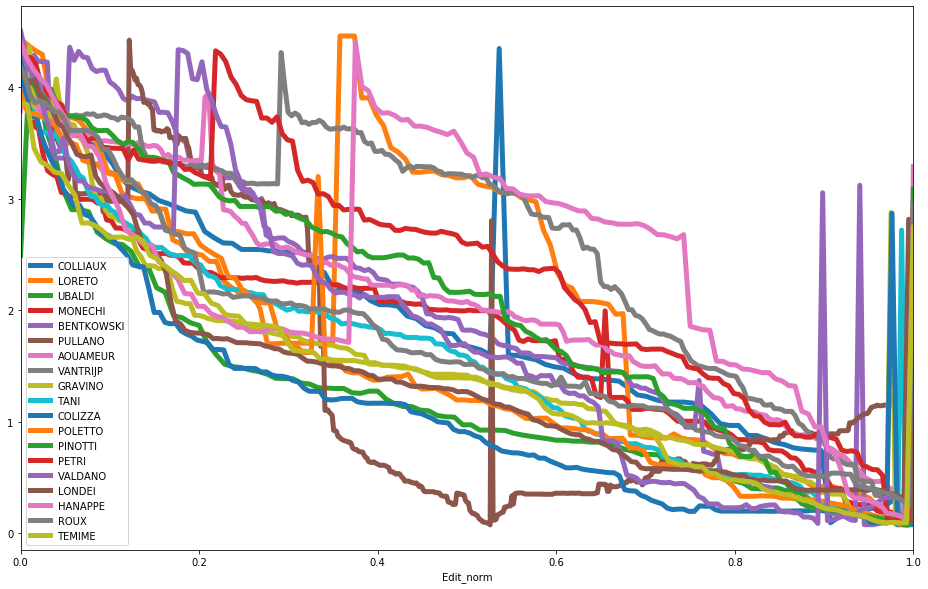

In [17]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
for i in range(len(Data)):
    Data[i]["Conv_df"].plot(ax=ax, x='Edit_norm', 
                            y='distance', figsize=(16, 10), linewidth=5, label=Data[i]['Name'])

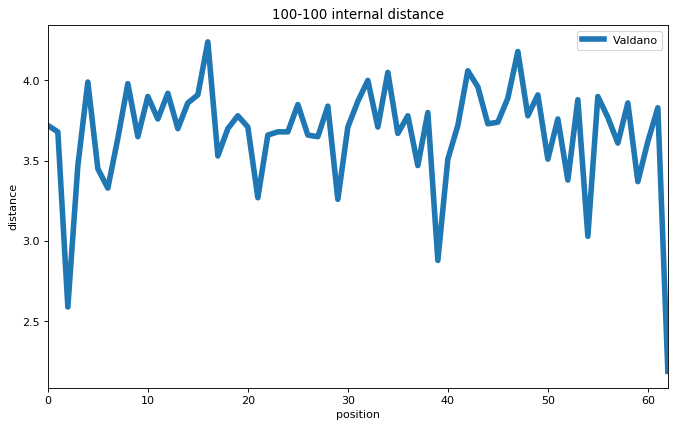

In [6]:
figure = plt.figure(figsize=(10,6), dpi=80)
ax = figure.add_subplot(111)
Sliding.plot(ax=ax,linewidth=5, label="100-100 internal distance")
plt.xlabel('position')
plt.ylabel('distance')
ax.legend(["Valdano"])
ax.set_title("100-100 internal distance")
plt.savefig("Jumpiness.jpg")

In [7]:
matrix = pd.DataFrame()
matrix['2019-01-30 17:54:00']= contigs['2019-01-30 17:54:00']['distance']
for key, distance in contigs.items():
    matrix[key] = distance['distance']
matrix = matrix.reindex(sorted(matrix.columns), axis=1)
matrix = matrix.sort_index()

KeyError: '2019-01-30 17:54:00'

In [ ]:
plt.pcolor(matrix)
plt.show()